# Model 4

# ODC (Optic Disc Cupping)  CNN Binary Model 

## Mark Whelly - BrainStation Data Science Bootcamp - August 2022

Transfer Learning Model using InceptionV3. Working on Google Colab Cloud environment.

This is the fourth of 5 models presented as part of this project.

This MODEL 4 is a binary classifier of retinal images, specifically looking for Optic-Disc Cupping (ODC).
ODC is related to the thinning of the neuroretinal rim around the optic nerve, and pathological ODC is generally referred to as glaucoma which can lead to blindness.

This CNN model only includes the images that show either:
    -Normal eye condition (class 0).
    -ODC only (class1). No other disease present.

The data originate from a scientific paper in the journal Data, as published by Pachade et al 2021. Data was obtained from the kaggle website, as provided by the user 'Larxel' under the dataset Retinal Image Classification.

All modeling work was done on the Google Colab environment using google GPU to increase modeling speeds.

In [1]:
import os

In [2]:
from google.colab import drive

In [3]:
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
cd/gdrive/My Drive/Retimages/Train/

/gdrive/My Drive/Retimages/Train


In [4]:
import numpy as np 
import pandas as pd
import zipfile

import csv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.python.keras.models import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from pathlib import Path
import os

import skimage
import skimage.io
from skimage import data, img_as_float
from skimage import exposure
from matplotlib import pyplot as plt

from matplotlib.pyplot import imread, imshow, show, subplot, title, get_cmap, hist
from skimage.exposure import equalize_hist

In [6]:
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten, GRU, Bidirectional
    from tensorflow.keras.optimizers import SGD
except:
    !pip install keras
    !pip install h5py==3.1.0 numpy==1.19.2 six==1.15.0 typing-extensions==3.7.4 wrapt==1.12.1 botocore==1.20.106 gast==0.4.0 tensorboard==2.6 tensorflow-estimator==2.6 absl-py==0.9 protobuf==3.11.2 scikit-learn==0.24 fsspec==2021.07.0 google-api-python-client==1.12.1
    !pip install --upgrade tensorflow
    !pip install --ignore-installed --upgrade tensorflow-gpu==1.15.0
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
    from tensorflow.keras.optimizers import SGD

In [7]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import shutil
from tqdm import tqdm

# PART 1 - Data Preparation and Organization

Grouping images into 2 separate folders (0 for Normal photos, and 1 for ODC images), within Retimages/Train/TrainODCeqh directory on Google Colab.

Similarly, Validation images were grouped into subfolder per 2 classes, within Retimages/Validation/ValidODCeqh, and Test images grouped into Retimages/Test/TestODCeqh.

Note that image preprocessing was conducted on all images and the model was run and compared with the model using the original non-enhanced images. In this case, the best results (recall, precision, accuracy) were seen with the histogram-Equalized images (EQH) and these images are used in the model below.

In [ ]:
# ALREADY RUN, do not rerun. 

# TRAINING IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode')
a=[] 

#ODC_Only, based on a 1 in col 1.
b=[] 

with open('../Train/TrainODC_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # odc_Only
        b.append(row[0]+'.png')

F.close() 
os.mkdir('./TrainODCeqh')

parent_dir="./TrainODCeqh"
directory1 = "0Normal" 
directory2 = "1ODConly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

FileExistsError: ignored

In [ ]:
# ALREADY RUN, do not rerun. 

save_path = './TrainODCeqh/0Normal'
for filename in a:
  shutil.copy('Training_set/'+filename,save_path)

save_path = './TrainODCeqh/1ODConly'
for filename in b:
  shutil.copy('Training_set/'+filename,save_path)

In [ ]:
cd/gdrive/My Drive/Retimages/Validation/

/gdrive/My Drive/Retimages/Validation


In [ ]:
# ALREADY RUN, do not rerun. 

# VALIDATION IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode'), goes in '0_Normal'
a=[]

# ODC_Only, based on a 1 in col 1 ('DisCode').
b=[]

with open('../Validation/Valid_ODC_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # ODC_Only
        b.append(row[0]+'.png')
      
F.close() 
os.mkdir('./ValidODCeqh')

In [ ]:
# ALREADY RUN, do not rerun. 

parent_dir="./ValidODCeqh"
directory1 = "0Normal" 
directory2 = "1ODConly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [ ]:
# ALREADY RUN, do not rerun. 

save_path = './ValidODCeqh/0Normal'
for filename in a:
  shutil.copy('Validation_set/'+filename,save_path)
save_path = './ValidODCeqh/1ODConly'
for filename in b:
  shutil.copy('Validation_set/'+filename,save_path)

In [ ]:
cd/gdrive/My Drive/Retimages/Test/

/gdrive/My Drive/Retimages/Test


In [ ]:
# ALREADY RUN, do not rerun. 

# TEST IMAGES READING
# 'Normal' as class 0, based on '0' in col 1 ('DisCode')
a=[]

# ARMD_Only, based on a 1 in col 1.
b=[]

with open('../Test/Test_ODC_Labels.csv','r') as F:
  reader=csv.reader(F)
  for row in reader:
      if(row[1]=='0'):  # Normal.
        a.append(row[0]+'.png')
      if(row[1]=='1'):  # ARMD_Only
        b.append(row[0]+'.png')
      #if(row[1])=='2'):  # Other disease cases (NOT USED)
        #c.append(row[0]+'.png')
F.close() 
os.mkdir('./TestODCeqh')

In [ ]:
# ALREADY RUN, do not rerun. 

parent_dir="./TestODCeqh"
directory1 = "0Normal" 
directory2 = "1ODConly"
path1 = os.path.join(parent_dir, directory1)
path2 = os.path.join(parent_dir, directory2)
os.mkdir(path1)
os.mkdir(path2)

In [ ]:
# ALREADY RUN, do not rerun. 

save_path = './TestODCeqh/0Normal'
for filename in a:
  shutil.copy('Test_set/'+filename,save_path)
save_path = './TestODCeqh/1ODConly'
for filename in b:
  shutil.copy('Test_set/'+filename,save_path)

In [10]:
# Preprocessing function to apply to all images

def hist_equalize(im, clahe=True, bgr=True):
    # Equalize histogram on BGR image 'im' with im.shape(n,m,3) and range 0-255
    yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV if bgr else cv2.COLOR_RGB2YUV)
    if clahe:
        c = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        yuv[:, :, 0] = c.apply(yuv[:, :, 0])
    else:
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])  # equalize Y channel histogram
    return cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR if bgr else cv2.COLOR_YUV2RGB)  # convert YUV image to RGB


In [32]:
# DO NOT RERUN

#TO ENHANCE IMAGES

# applying hist_equalize to TRAIN DR eqh normals
from skimage import data, img_as_float
from skimage import exposure
import cv2
from tensorflow.python.keras.utils.data_utils import Sequence
import warnings
warnings.filterwarnings("ignore")
destination_path = '/gdrive/My Drive/Retimages/Train/TrainODCeqh/0Normal/'
origin_path = '/gdrive/My Drive/Retimages/Train/TrainODConly/0Normal/'
format_of_your_images = '.png'
all_the_files = Path(origin_path).rglob(f'*{format_of_your_images}')

In [33]:
# DO NOT RERUN

# actual augmentation of eqh per image:
for f in all_the_files:
  img_in = cv2.imread(str(f))
  #  transformation
  img_histeq = hist_equalize(img_in)
  #writing to target folder
  cv2.imwrite(f'{destination_path}/{f.name}', img_histeq)


In [34]:
cd/gdrive/My Drive/Retimages/

/gdrive/My Drive/Retimages


In [35]:
from google.colab.patches import cv2_imshow

In [ ]:
cd/gdrive/My Drive/Retimages/

/gdrive/My Drive/Retimages


In [ ]:
# DO NOT RERUN

# TO AUGMENT NUMBER OF IMAGES:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(        
        rotation_range = 30,
        vertical_flip = True,
        horizontal_flip = True,
        fill_mode = 'constant',
        cval = 1)
import numpy as np
import os
from PIL import Image

# augmenting TRAIN ODC set of  pics:
image_directory = os.path.join('./Test/TestODCeqh/1ODConly/')
dataset = []
my_images = os.listdir(image_directory)
for i, image_name in enumerate(my_images):    
    if (image_name.split('.')[1] == 'png'):        
        image = io.imread(image_directory + image_name)        
        image = Image.fromarray(image, 'RGB')        
        image = image.resize((536,356)) 
        dataset.append(np.array(image))
x = np.array(dataset)
i = 0
for batch in datagen.flow(x, batch_size=18,
                          save_to_dir= os.path.join('./Test/TestODCeqh/Aug/'),
                          save_prefix='dr3',
                          save_format='png'):    
    i += 1    
    if i > 0:        
        break

In [36]:
# count files per group

train_abnormal_dir = os.path.join('./Train/TrainODCeqh/1ODConly')
train_normal_dir = os.path.join('./Train/TrainODCeqh/0Normal')
train_abnormal_names = os.listdir(train_abnormal_dir)
train_normal_names = os.listdir(train_normal_dir)
print('total training images with ODC:', len(os.listdir(train_abnormal_dir)))
print('total training images of normal eyes:', len(os.listdir(train_normal_dir)))

total training images with ODC: 238
total training images of normal eyes: 401


In [37]:
Num_Train_Images = len(os.listdir(train_abnormal_dir)) + len(os.listdir(train_normal_dir))
Num_Train_Images

639

In [38]:
validation_abnormal_dir = os.path.join('./Validation/ValidODCeqh/1ODConly')
validation_normal_dir = os.path.join('./Validation/ValidODCeqh/0Normal')
validation_abnormal_names = os.listdir(validation_abnormal_dir)
validation_normal_names = os.listdir(validation_normal_dir)
print('total validation images with ODC:', len(os.listdir(validation_abnormal_dir)))
print('total validation images of normal eyes:', len(os.listdir(validation_normal_dir)))


total validation images with ODC: 72
total validation images of normal eyes: 134


In [39]:
Num_Validation_Images = len(os.listdir(validation_abnormal_dir)) + len(os.listdir(validation_normal_dir))
Num_Validation_Images

206

In [40]:
test_abnormal_dir = os.path.join('./Test/TestODCeqh/1ODConly')
test_normal_dir = os.path.join('./Test/TestODCeqh/0Normal')
test_abnormal_names = os.listdir(test_abnormal_dir)
test_normal_names = os.listdir(test_normal_dir)
print('total Test images with ODC:', len(os.listdir(test_abnormal_dir)))
print('total Test images of normal eyes:', len(os.listdir(test_normal_dir)))


total Test images with ODC: 72
total Test images of normal eyes: 134


In [41]:
Num_Test_Images = len(os.listdir(test_abnormal_dir)) + len(os.listdir(test_normal_dir))
Num_Test_Images

206

The dataset was split into train:validation:test sets with 60/20/20 ratios. The ratio of healthy to disease eye images was maintained the same in train, test and validation sets.

## Image Data Generators

In [43]:
# Original (non-equalized) images were used here.

height = 150
width = 220
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 30,
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   fill_mode='constant',cval=1)


train_generator = train_datagen.flow_from_directory('./Train/TrainODCeqh', 
                                                    target_size=(height,width), 
                                                    color_mode='rgb',
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    class_mode='categorical')


Found 639 images belonging to 2 classes.


In [44]:
# define x_train and y_train from train generator: 
X_train, y_train = train_generator.next() 

In [45]:
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory('./Validation/ValidODCeqh', 
                                                              target_size=(height,width),
                                                              color_mode='rgb',
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=True,
                                                              class_mode='categorical')

Found 206 images belonging to 2 classes.


In [46]:
train_generator.class_indices

{'0Normal': 0, '1ODConly': 1}

In [47]:
validation_generator.class_indices

{'0Normal': 0, '1ODConly': 1}

# Pretrained CNN Model

In [212]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [214]:
# load InceptionNetV3 model
model=InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(height,width,3))

KeyboardInterrupt: ignored

# Transfer Learning Model

In [ ]:
# Freeze all the layers in the base model
for layer in model.layers:
    layer.trainable = False

# remove last 2 layers of base inceptivev3 model
front_output = model.get_layer('mixed9').output

# Dropout Layer
dl_output = Dropout(0.55)(front_output) 

# add flatten layer and dense layers

flat_output = Flatten()(dl_output)
d1 = Dense(256, activation='relu')(flat_output)
d2 = Dense(64, activation='relu')(d1)
d3 = Dense(16, activation='relu')(d2)
#d4 = Dense(16, activation='relu')(d3)
#d5 = Dense(16, activation='relu')(d4)

# add output layer
output = Dense(2, activation='softmax')(d3)  # changed to 2 from 1 class.

# create final model object
model = Model(inputs=model.input, 
              outputs=output)

In [208]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 150, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1034 (Conv2D)           (None, 74, 109, 32)  864         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_1034 (Batc  (None, 74, 109, 32)  96         ['conv2d_1034[0][0]']            
 hNormalization)                                                                                  
                                                                                       

### Training the Model

In [209]:
# Trying ReduceLRonPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=1,cooldown=1, min_lr=1e-5)

In [210]:
#compile the InceptionV3 model with RMSprop
model.compile(optimizer='RMSprop',loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.3),tf.keras.metrics.AUC()])

In [211]:
# set class weight dictionary for imabalanced training set
classweights = {0:2,1:1} # given we have twice as many class 0 normals as class 1 ODC cases, this rebalances weights

history = model.fit(train_generator,
                    epochs=7,
                    validation_data = validation_generator,
                    batch_size = 16,
                    class_weight = classweights,
                    callbacks=[reduce_lr])

Epoch 1/7


ValueError: ignored

# Test Set

In [ ]:
cd/gdrive/My Drive/Retimages/Test

In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory('./Test/TestODCeqh',
                                                  target_size=(height,width),
                                                  color_mode='rgb',
                                                  batch_size=206,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

# Model Predictions and Evaluation

In [200]:
predict_probas = model.predict(X_test)
predict_probas.shape

(206, 2)

In [201]:
# Convert probabilities to label encoding
y_predict = np.argmax(predict_probas, axis=1)

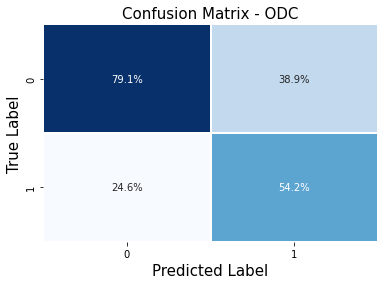

In [202]:
# Construct the confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Convert our test labels from one-hot encoding to label encoding
y_test_labels = np.argmax(y_test,axis=1)

conf_mat = confusion_matrix(y_test_labels,y_predict)
normalized_conf_mat = conf_mat / conf_mat.sum(axis=1)

plt.figure()
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            fmt='.1%',
            cmap="Blues",
            linewidths=1
           )
plt.title('Confusion Matrix - ODC',size = 15,y=1.01)
plt.xlabel("Predicted Label", size = 15)
plt.ylabel("True Label", size = 15)
plt.show()

The above matrix shows acceptable recall, precision and test accuracy for detection of ODC cases in retinal images. See classification report below.

In [152]:
print('F1 Score: %.3f' % f1_score(y_test_labels, y_predict))

F1 Score: 0.637


In [203]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test_labels, y_predict)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.79      0.78       134
           1       0.58      0.54      0.56        72

    accuracy                           0.70       206
   macro avg       0.67      0.67      0.67       206
weighted avg       0.70      0.70      0.70       206



dict_keys(['loss', 'binary_accuracy', 'auc_8', 'val_loss', 'val_binary_accuracy', 'val_auc_8', 'lr'])


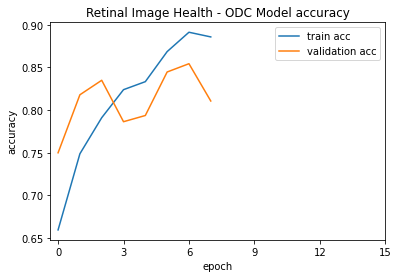

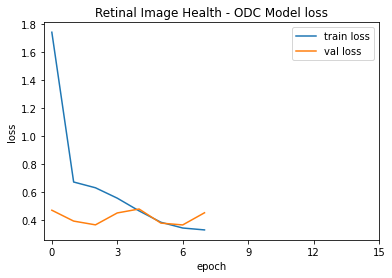

In [191]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Retinal Image Health - ODC Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train acc', 'validation acc'])
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Retinal Image Health - ODC Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,18,3))
plt.legend(['train loss', 'val loss'])
plt.show()

In [ ]:
# save model
model.save('Eye_ODC_Binary__Incept_24Aug2022.h5')

In [ ]:
pip install scikit-plot

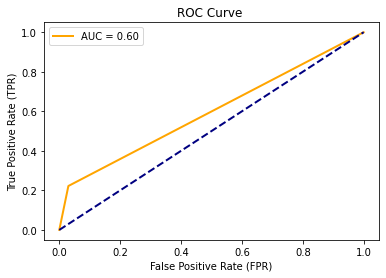

Area under curve (AUC):0.5961857379767828



In [ ]:
# Plot of ROC Curves per Class

from IPython.core.pylabtools import figsize
import scikitplot as skplt
import matplotlib.pyplot as plt
skplt.metrics.plot_roc(y_test_labels, predict_probas)
plt.figure(figsize=(14,12),dpi=100)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

fprs, tprs, thresholds = roc_curve(y_test_labels, y_predict) 
roc_auc = roc_auc_score(y_test_labels, y_predict)  

plt.figure()
plt.plot(fprs, tprs, color='orange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - ODC Model ')
plt.legend(loc="best")
plt.show()

#### Incorrectly Predicted Images
As our final evaluation of our model, we will look at the images that were incorrectly predicted to see if there are any patterns.

In [155]:
import math

incorrect_photos = y_test_labels != y_predict

num_images = np.count_nonzero(incorrect_photos)
columns = 3
rows = math.ceil(num_images / columns)

fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(12,3*rows))
axes = axes.flatten()

for i, image in enumerate(X_test[incorrect_photos]):
    axes[i].imshow(image, cmap='gray')

    # Get predicted label
    #predicted_label = labels[y_predict[incorrect_photos][i]]
    predicted = y_predict[incorrect_photos][i]

    # Get actual label
    #true_label =  labels[y_test_labels[incorrect_photos][i]]
    actual = y_test_labels[incorrect_photos][i]
    
    #Get filename of image
    filenam = test_generator.filenames[i]
    x=filenam[8:]

    # Set the title of the subplot
    axes[i].set_title(f"\n IMAGE: {x} \n Predicted: {predicted}   True: {actual}\n")
    
    # Hide the x and y ticks to make 
    axes[i].set_xticks([]) 
    axes[i].set_yticks([])
    
fig.tight_layout()
# Hide unused subplots
for i in range(num_images, rows*columns):
    fig.delaxes(axes[i])
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [156]:
# Find all misclassified images in a given test set

MISCLASSIFIED = num_images

# Accuracy calculations
total = Num_Test_Images
num_correct = total - (MISCLASSIFIED)
accuracy = num_correct/total

print('Accuracy: ' + str(accuracy))
print(f"Number of misclassified images = {MISCLASSIFIED}  out of {total}")

Accuracy: 0.7233009708737864
Number of misclassified images = 57  out of 206


# Concluding Remarks

This model provided great binary classification results for evaluating if eyes are healthy or show signs of Optic Disc Cupping. The model showed 74% recall, 76% precision, and 74% test accuracy.